In [23]:
import matplotlib.pyplot as plt
import numpy as np
from layouts import keyboard_layouts
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
import json

In [24]:
print(list(keyboard_layouts.keys()))

['qwerty', 'dvorak', 'colemak', 'ergodox', 'best_layout']


In [25]:
class Key:
    def __init__(
        self, ind, char, x, y, width, height, side, start, shift_char=None, freq=0
    ):
        self.ind = ind
        self.char = char
        self.shift_char = shift_char
        self.freq = freq
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.travel = 0
        self.start = start
        self.side = side

In [26]:
KEY_FONT = "DejaVu Sans Mono"
KEYBOARD_BG_COLOR = "#1c1c1c"
DEFAULT_KEY_COLOR = "#656363"

In [27]:
class Keyboard:
    def __init__(self, s):
        # select layout
        self.listed_keyboard_layout = keyboard_layouts[s.lower()]
        self.total_travel = 0
        self.store_layout()
        self.calc_travel()
        
    def store_layout(self):
        self.key_index = {}
        self.keyboard_layout = []
        self.swapable_keys = []
        movable_chars = "abcdefghijklmnopqrstuvwxyz`[]\;',./-="
        # movable_chars = "abcdefghijklmnopqrstuvwxyz`[]\;',./-=1234567890"
        
        index = 0
        x_start = 100.0
        y_start = -100.0
        x_end = -100.0
        y_end = +100.0
        for key in self.listed_keyboard_layout:
            # set properties
            chars = key["chars"]
            (x, y) = key["position"]
            (w, h) = key["dimensions"]
            start = key["start"]
            normal_char = chars[0]
            side = key["side"]

            if len(chars) > 1:
                shift_char = chars[1]
                self.key_index[shift_char] = index
            else:
                shift_char = None

            if normal_char in movable_chars:
                self.swapable_keys.append(index)
            
            # append to list
            keyobj = Key(
                index,
                normal_char,
                shift_char=shift_char,
                x=x,
                y=y,
                width=w,
                height=h,
                start=start,
                side=side,
            )
            self.keyboard_layout.append(keyobj)
            self.key_index[normal_char] = index  # map characters to keys

            index += 1

            x_start = min(x_start, x)
            y_start = max(y_start, y + h)
            x_end = max(x_end, x + w)
            y_end = min(y_end, y)

        # dimensions of the keyboard
        self.x_start = x_start
        self.y_start = y_start
        self.x_end = x_end
        self.y_end = y_end

        # map space and new line keys
        self.key_index[" "] = self.key_index["SPACE"]
        self.key_index["\n"] = self.key_index["ENTER"]
        self.key_index['\b'] = self.key_index["BACKSPACE"]
    
    # Function to display the keys according to the specified order
    def display_keys(self,order=None):
        if order == None:
            order = [i for i in range(len(self.keyboard_layout))]
        # define plot
        self.fig, self.ax = plt.subplots(
            figsize=(
                (self.x_end - self.x_start) * 12 / 16,
                (self.y_start - self.y_end) * 8 / 6.5,
            )
        )
        self.fig.patch.set_facecolor(KEYBOARD_BG_COLOR)

        # store the key pieces in a list
        self.rectangles = []
        ind = 0
        # display the keys
        for key_obj in self.keyboard_layout:
            key_color = DEFAULT_KEY_COLOR
            x_pos, y_pos, width, height = (
                key_obj.x,
                key_obj.y,
                key_obj.width,
                key_obj.height,
            )

            # rectangle with curved corners
            rect = FancyBboxPatch(
                (x_pos, y_pos),
                width,
                height,
                edgecolor="black",
                facecolor=key_color,
                boxstyle="round,pad=0.0,rounding_size=0.1",
            )

            self.rectangles.append(rect)
            self.ax.add_patch(rect)

            key = key_obj.char
            freq = key_obj.freq
            shift_key = key_obj.shift_char

            actual_obj = self.keyboard_layout[order[ind]]
            key = actual_obj.char
            shift_key = actual_obj.shift_char
            # display text and shift text
            label = key.upper()
            self.ax.text(
                x_pos + width / 2,
                y_pos + height / 2,
                label,
                ha="center",
                va="center",
                fontsize=10,
                font=KEY_FONT,
                zorder=100,
            )


            if shift_key != None and not shift_key.isalpha():
                self.ax.text(
                    x_pos + width / 5,
                    y_pos + 0.75,
                    shift_key.upper(),
                    ha="center",
                    va="center",
                    fontsize=10,
                    font=KEY_FONT,
                    zorder=100,
                )
            ind+=1

        # display keyboard
        self.ax.set_xlim(self.x_start, self.x_end)
        self.ax.set_ylim(self.y_end, self.y_start)
        self.ax.set_aspect("equal")
        self.ax.axis("off")
        # plt.draw()
        # plt.pause(0.01)
        self.clrmsk = 0


    # creates radial color mask at given position and of given radius
    def create_radial_gradient(self, grayscale, xcentre, ycentre, xradius, yradius):
        mid = grayscale * 0.8

        # Calculate coordinates and radii in normalized units
        x0 = int(self.xRES * (xcentre - self.x_start) / (self.x_end - self.x_start))
        y0 = int(self.yRES * (ycentre - self.y_start) / (self.y_end - self.y_start))
        rx = abs(int(self.xRES * xradius / (self.x_end - self.x_start)))
        ry = abs(int(self.yRES * yradius / (self.y_end - self.y_start)))

        # define the range of the gradient
        fact = 3
        xmin = max(0, x0 - fact * rx)
        xmax = min(self.xRES, x0 + fact * rx)
        ymin = max(0, y0 - fact * ry)
        ymax = min(self.yRES, y0 + fact * ry)

        # Create meshgrid of x and y coordinates
        x = np.arange(xmin, xmax)
        y = np.arange(ymin, ymax)
        xx, yy = np.meshgrid(x, y)

        # Calculate distances from the center
        r = np.sqrt((xx - x0) ** 2 + (yy - y0) ** 2)

        # Calculate grayscale and alpha values with gaussian distribution
        val = mid * np.exp(-(r**2) * 0.0005)
        alpha = mid * np.exp(-(r**2) * 0.0004)

        # Add to prexisting values
        self.grey_mask[-yy - 1, xx] = np.minimum(0.9, val + self.grey_mask[-yy - 1, xx])
        self.alpha_mask[-yy - 1, xx] = np.minimum(
            0.8, alpha + self.alpha_mask[-yy - 1, xx]
        )
        # display keyboard
        self.ax.set_xlim(self.x_start, self.x_end)
        self.ax.set_ylim(self.y_end, self.y_start)
        self.ax.set_aspect("equal")
        self.ax.axis("off")
        # plt.draw()
        # plt.pause(0.01)
        self.clrmsk = 0
        
    # generate color map from
    def colorize(self):
        self.cmap = plt.cm.jet
        colored = self.cmap(self.grey_mask)
        colored[..., 3] = self.alpha_mask
        self.color_mask = colored
        

    # function to draw heat map on the keyboard according to the specified order
    def draw_keyboard_layout(self,order=None):
        if order == None:
            order = [i for i in range(len(self.keyboard_layout))]
        # set resolution of heatmap
        self.xRES = 1000
        self.yRES = abs(
            int(self.xRES * (self.y_end - self.y_start) / (self.x_end - self.x_start))
        )

        # initialise numpy arrays
        self.color_mask = np.zeros((self.yRES, self.xRES, 4))
        self.grey_mask = np.zeros((self.yRES, self.xRES))
        self.alpha_mask = np.zeros((self.yRES, self.xRES))

        # clear heat map
        if self.clrmsk:
            self.clrmsk.remove()

        ind = 0
        for key_obj in self.keyboard_layout:
            freq = self.keyboard_layout[order[ind]].freq
            x_pos, y_pos, width, height = (
                key_obj.x,
                key_obj.y,
                key_obj.width,
                key_obj.height,
            )

            if freq and self.THRESH:
                # define offset of heatmap around the key
                offset = 0.6
                # create the gradient on the heatmap array
                self.create_radial_gradient(
                    grayscale=(freq / self.THRESH),
                    xcentre=x_pos + width / 2,
                    ycentre=y_pos + height / 2,
                    xradius=width / 2 + offset,
                    yradius=height / 2 + offset,
                )
            ind+=1
            
        # colorize the grayscale array
        self.colorize()

        # show the heatmap over the keys
        self.clrmsk = self.ax.imshow(
            self.color_mask,
            extent=(self.x_start, self.x_end, self.y_end, self.y_start),
            origin="lower",
            zorder=5,
        )
        
        self.ax.set_xlim(self.x_start, self.x_end)
        self.ax.set_ylim(self.y_end, self.y_start)
        self.ax.set_aspect("equal")
        self.ax.axis("off")
    
    # calculates the travel of each key and stores in "key travel" array
    def calc_travel(self):
        self.key_travel = [0 for _ in range(len(self.keyboard_layout))]
        for key in self.keyboard_layout:
            x1, y1 = key.x + key.width / 2, key.y + key.height / 2
            start_key = self.keyboard_layout[self.key_index[key.start]]
            x2, y2 = (
                start_key.x + start_key.width / 2,
                start_key.y + start_key.height / 2,
            )
            key.travel = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            self.key_travel[key.ind] = key.travel
    
    # calculates the frequency of characters in the provided string and
    def calc_frequency(self,s):
        self.char_freq = [0 for i in range(len(self.keyboard_layout))]
        self.THRESH = 0
        for c in s:
            if c not in self.key_index:  # ignore unusual characters
                continue
            if c ==" ":
                continue
            ind = self.key_index[c]
            self.char_freq[ind]+=1
            key = self.keyboard_layout[ind]
            key.freq+=1
            self.THRESH = max(key.freq,self.THRESH)
            if key.shift_char == c:
                shift = "R" if key.side == "L" else "L"
                shift_ind = self.key_index[shift + "SHIFT"]
                self.keyboard_layout[shift_ind].freq+=1
                self.char_freq[shift_ind]+=1
                self.THRESH = max(self.keyboard_layout[shift_ind].freq,self.THRESH)
    
    # calculates the total travel distance for given order of keys
    def calc_total_travel(self,order):
        res = 0
        for i in range(len(self.keyboard_layout)):
            ind = order[i]
            res+=self.key_travel[i]*self.char_freq[ind]
        return res

    # function to randomly select two keeys from the movable set of keys and swap them
    def get_neighbour(self, order):
        new_order = order.copy()
        i, j = random.sample(self.swapable_keys,2)
        new_order[i], new_order[j] = new_order[j], new_order[i]
        return new_order
    
    def simulated_annealing(self, num_iterations, initial_temp, cooling_rate):
        """
        Args:
            num_iterations : Number of random swaps to perform
            initial_temp : initial value of variable to damp random undefined swaps
            cooling_rate : factor to decrease temp variable

        Returns:
            bester_oders : best order generated while annhealing
            best_travels : travels of the best oders
            travels : travel after each iteration
        """
        
        self.initial_order = [i for i in range(len(self.keyboard_layout))] # inital order is the natural order of the layout
        # random.shuffle(initial_order)
        
        current_order = self.initial_order
        best_order = current_order.copy()
        
        current_travel = self.calc_total_travel(current_order)
        best_travel = current_travel
        
        temp = initial_temp
        travels = [current_travel]
        best_travels = [best_travel]
        best_orders = [best_order]
        self.count=0 # tracks random jump count
        
        for i in range(num_iterations):
            neighbour_order = self.get_neighbour(current_order)
            neighbour_travel = self.calc_total_travel(neighbour_order)
            
            # variable to determine probability of undefined swaps
            p = np.exp((current_travel-neighbour_travel)/(4*temp*current_travel))
            
            # Update if the travel is reduced
            if neighbour_travel < current_travel or random.random()<p:
                if neighbour_travel>current_travel:
                    self.count+=1
                
                current_order = neighbour_order
                current_travel = neighbour_travel
                
                # update best travel if the total travel is least
                if current_travel < best_travel:
                    best_order = current_order.copy()
                    best_travel = current_travel
        
            temp *= cooling_rate
            
            travels.append(current_travel)
            best_orders.append(best_order.copy())
            best_travels.append(best_travel)
        
        return best_orders, best_travels, travels    
    
    
    def run(self,num_iterations=100, animate=False):
        """
        Args:
            num_iterations : Number of annealing iterations. Defaults to 100.
            animate : Displays animation if True. Defaults to False.

        """
        initial_temp = 100
        cooling_rate = 0.995
        self.num_iterations = num_iterations

        # call anealing function
        self.best_orders, self.best_travels, self.travels = self.simulated_annealing(self.num_iterations,initial_temp,cooling_rate)
        self.best_order = self.best_orders[-1]
        
        # display animation if required
        if animate:
            anim = self.animate(num_iterations)
            display(HTML(anim.to_jshtml()))
    
    # function to plot the travels during annealing (non animated)
    def plot_progress(self):
        fig3, ax3 = plt.subplots(figsize=(5,5))
        x = [i for i in range(self.num_iterations+1)]
        ax3.plot(x,self.travels,'r-',label='Travel distance')
        ax3.plot(x,self.best_travels,'g-',label='Best travel distance')
      
        ax3.set_xlabel('Iterations')
        ax3.set_ylabel('Travel Distance')
        ax3.legend(loc="upper right")

    # updates plot for animation
    def update(self,frame, travel_line, best_travel_line, travels, best_travels):
        x = [i for i in range(frame)]
        travel_line.set_data(range(frame+1), travels[:frame+1])
        best_travel_line.set_data(range(frame + 1), best_travels[:frame + 1])
        return travel_line, best_travel_line  
    
    # Performs animation
    def animate(self, num_iterations):
        # define graph
        fig2, ax2 = plt.subplots(figsize=(5,5))
        ax2.set_xlim(0, num_iterations)
        ax2.set_ylim(min(self.travels) * 0.9, max(self.travels) * 1.1)
        
        # define plot
        travel_line, = ax2.plot([],[],'r-',label='Travel distance')
        best_travel_line, = ax2.plot([],[],'g-',label='Best travel distance')
        ax2.legend(loc="upper right")
        
        """
        create animation
        fig2 - plot to be modified
        update - function that perform the modification
        frame - No of time to call update function
        fargs - arguments of the update function
        interval - time dedicated to each frame. Here it is defined 
        such that the total animation time is always 10 seconds
        """
        anim = FuncAnimation(fig2, self.update, frames = range(num_iterations),
                             fargs = (travel_line, best_travel_line, self.travels, self.best_travels),
                             interval = 10000/num_iterations, blit=True, repeat=False)
        
        return anim  # return animation
    
    # function to save the generated layout in the standard format
    def save_layout(self,filename):
        new_layout = []
        swap_dict = {}
        
        # create a dictionary to map the changes
        for i in range(len(self.best_order)):
            swap_dict[self.keyboard_layout[i].char]=self.keyboard_layout[self.best_order[i]].char
        
        # for each element change only the character associated with the key and the start key
        for value in self.listed_keyboard_layout:
            new_value = value.copy()
            
            # swap start key
            new_value['start'] = swap_dict[new_value['start']]
            
            # swap characters
            chars = new_value['chars'] 
            ind = self.key_index[swap_dict[chars[0]]]
            new_chars = self.listed_keyboard_layout[ind]['chars'].copy()
            new_value['chars'] = new_chars
            
            # append to list
            new_layout.append(new_value)
        
        # save the list of dictionaries into file
        with open(filename, 'w') as file:
            file.write("[\n")
            file.write(",\n".join(json.dumps(element, separators=(', ', ': ')) for element in new_layout))
            file.write("\n]")


In [28]:
# read string from file (ignore unusual characters if any)
with open('string.txt','r', encoding='utf-8', errors='ignore') as file:
    s = file.read()

# define keyboard with desired layout
keyboard = Keyboard('qwerty')
keyboard.calc_frequency(s)   # calculate frequency of characters in the string

# run annhealing
keyboard.run(5000, animate=False)

C:\Users\bhave\AppData\Local\Temp\ipykernel_98660\953351034.py:346: RuntimeWarning: overflow encountered in exp
  p = np.exp((current_travel-neighbour_travel)/(4*temp*current_travel))


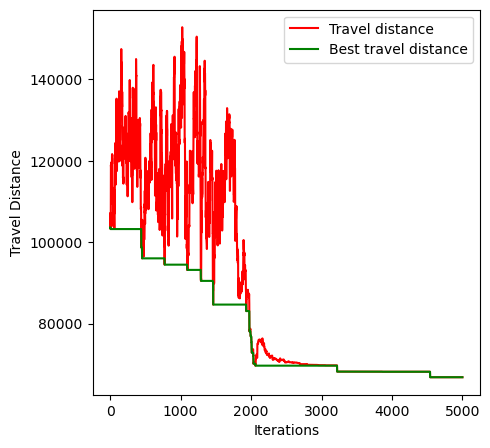

In [29]:
# Plot annhealing progress
keyboard.plot_progress()

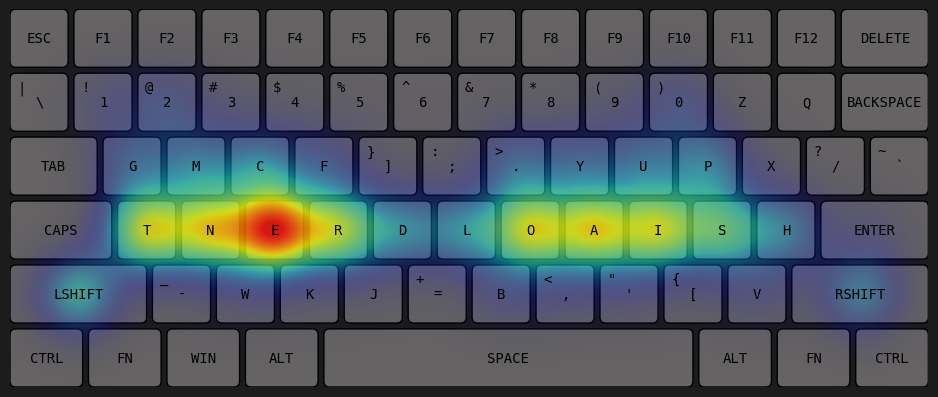

In [30]:
# display the optimized keyboard
keyboard.display_keys(keyboard.best_order)
keyboard.draw_keyboard_layout(keyboard.best_order)

In [31]:
print('Initial Travel distance   =',keyboard.best_travels[0])
print('Final Travel distance =',keyboard.best_travels[-1])
print('improvement = ', int((keyboard.best_travels[0]-keyboard.best_travels[-1])*100/keyboard.best_travels[0]),'%')

Initial Travel distance   = 103611.90657212211
Final Travel distance = 66835.98353431466
improvement =  35 %


In [32]:
# save generated layout in text file
keyboard.save_layout('output_layout.txt')

# Optimized Layout Analysis

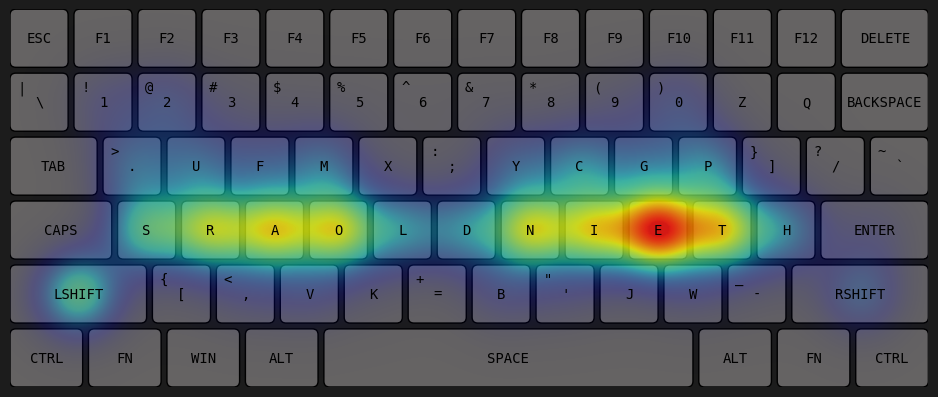

In [33]:
# display best layout from layouts.py
best_keyboard = Keyboard('best_layout')
best_keyboard.calc_frequency(s)
best_keyboard.display_keys()
best_keyboard.draw_keyboard_layout()